In [1]:
from collections import namedtuple, OrderedDict
from functools import partial
import numpy as np

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

import matplotlib.pyplot as plt
%matplotlib inline  
import glob
import os
import re 
import seaborn as sb
import pprint
#from pprint import pprint as print
from IPython.display import display, HTML

path = f'{os.environ["HOME"]}/exposure-bias-results/exposure-bias/*/*'
runs = glob.glob(path)
runs = list(filter(lambda x: os.path.isfile(os.path.join(path, x, 'test_results.csv')), runs))

runs = list(filter(lambda x: "Clb" in x, runs))  # filter for CelebA
#runs = list(filter(lambda x: "2021-08-10" in x, runs)) # filter for date
assert len(runs) > 0
print(len(runs), "runs loaded.")

files = list(map(lambda f: os.path.join(f, 'test_results.csv'), runs))

25877 runs loaded.


In [2]:
def get_hparams(run_descriptor):
    
    def get_hparam(regex, hparam_type):
        return hparam_type(re.search(regex, run_descriptor).group(1))
    
    rho0 = get_hparam('rh0_([01]\.[0-9]+)', float)
    rho1 = get_hparam('rh1_([01]\.[0-9]+)', float)
    model = get_hparam('(ResNet[0-9]*)', str)
    width = get_hparam('width=([0-9]*)', int)
    seed = get_hparam('rndm_sd=([0-9]*)', int)
    
    discriminator = get_hparam('dscrmntr_([A-Za-z_]+)', str)
    distractor = get_hparam('dstrctr_([A-Za-z_]+)', str)
    
    attributes = {
        'Mth_Slghtl_pn': 'mouth slightly open',
        'Wrng_Lpstck': 'wearing lipstick',
        'Ml': 'male',
        'Hgh_Chkbns': 'high cheekbones',
        'Blnd_Hr': 'blond hair',
        'rchd_brws': 'arched eyebrows',
    }
    discriminator = attributes[discriminator]
    distractor = attributes[distractor]
  
    hparams = {
        'rho_0': rho0,
        'rho_1': rho1,
        'model': model,
        'width': width,
        'seed': seed,
        'discriminator_attribute': discriminator,
        'distractor_attribute': distractor,
    }
    return hparams
    
dfs = []
for fname in files:
    fpath = os.path.join(path, fname)
    hparams = get_hparams(fpath.split('/')[-2])
    #print(fpath)
    #print(hparams)
        
    df = pd.read_csv(fpath)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    for k, v in hparams.items():
        df[k] = v
    dfs.append(df)

idx = -1
print("Example results file:", files[idx])

Example results file: /Users/eringrant/exposure-bias-results/exposure-bias/ee2c907/2021-10-03-04:40-26544_rndm_sd=25_dtst_nme='bsd_xpsr_clb_-Clb-rh0_0.825-rh1_0.25-dscrmntr_Mth_Slghtl_pn-dstrctr_Wrng_Lpstck'_model=@ResNet18_model=@ResNet18_width=2/test_results.csv


In [3]:
def p(df):
    display(HTML(df.to_html()))

def summarize_df(df):
    Result = namedtuple('Result', ('rho_0', 'rho_1',
                                   'discriminator_attribute',
                                   'distractor_attribute',
                                   'model',
                                   'width',
                                   'accuracy', 
                                   #'std_accuracy', 
                                   #'CI95_accuracy',
                                  ))
    return Result(float(df['rho_0'].unique()[0]), float(df['rho_1'].unique()[0]), 
                  df['discriminator_attribute'].unique()[0],
                  df['distractor_attribute'].unique()[0],
                  df['model'].unique()[0],
                  df['width'].unique()[0],
                  df['correct'].mean(),
                  )


# Partition test data into 2x2 conditions.
def filter_quadrants(df, disc, dist):
    return df.query(f'discriminator == {disc} & distractor == {dist}')

off_off_filter = partial(filter_quadrants, disc=0, dist=0)
on_off_filter = partial(filter_quadrants, disc=1, dist=0)
off_on_filter = partial(filter_quadrants, disc=0, dist=1)
on_on_filter = partial(filter_quadrants, disc=1, dist=1)

unfiltered_on_on_DF = pd.DataFrame(data=map(summarize_df, map(on_on_filter, dfs)))
unfiltered_on_off_DF = pd.DataFrame(data=map(summarize_df, map(on_off_filter, dfs)))
unfiltered_off_on_DF = pd.DataFrame(data=map(summarize_df, map(off_on_filter, dfs)))
unfiltered_off_off_DF = pd.DataFrame(data=map(summarize_df, map(off_off_filter, dfs)))
unfiltered_all_quadrants_DF = pd.DataFrame(data=map(summarize_df, dfs))

In [4]:
# Thresholding by accuracy on the training distribution:
# If rho_0 > 0.0, then check off_on
# If rho_0 < 1.0, then check off_off
# If rho_1 > 0.0, then check on_on
# If rho_1 < 1.0, then check on_off
threshold = 0.75
valid_idx = (unfiltered_all_quadrants_DF['rho_0'] == 0.0) | (unfiltered_off_off_DF['accuracy'] > threshold)
valid_idx &= (unfiltered_all_quadrants_DF['rho_0'] == 1.0) | (unfiltered_off_off_DF['accuracy'] > threshold)
valid_idx &= (unfiltered_all_quadrants_DF['rho_1'] == 0.0) | (unfiltered_on_on_DF['accuracy'] > threshold)
valid_idx &= (unfiltered_all_quadrants_DF['rho_1'] == 1.0) | (unfiltered_on_off_DF['accuracy'] > threshold)

off_off_DF = unfiltered_off_off_DF[valid_idx]
on_off_DF = unfiltered_on_off_DF[valid_idx]
off_on_DF = unfiltered_off_on_DF[valid_idx]
on_on_DF = unfiltered_on_on_DF[valid_idx]
all_quadrants_DF = unfiltered_all_quadrants_DF[valid_idx]

print(f"{sum(valid_idx)} out of {len(valid_idx)} valid results.")

14635 out of 25877 valid results.


### Check performance on the extrapolation quadrant.

In [5]:
from statistics import NormalDist

def ci95(x, confidence=0.95):
    if len(x) < 2:
        return np.NaN
    dist = NormalDist.from_samples(x)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    return dist.stdev * z / ((len(x) - 1) ** .5)

def logit(p):
    return np.log(p / (1 - p))

def mean_of_logit(x):
    return np.mean(np.array(x)) * 100
    #return np.mean(logit(np.array(x)))
    
def ci95_of_logit(x):
    return ci95(np.array(x)) * 100
    #return ci95(logit(np.array(x)))

def mean_ci95_string(x):
    return f"{mean_of_logit(x) * 1:.2f}   ±   {ci95_of_logit(x) * 1:.2f}%    (N={len(x)})"

def pivot(df):
    return pd.pivot_table(df, 
                          values='accuracy', 
                          aggfunc=(mean_ci95_string,),
                          index=['discriminator_attribute',
                                 'distractor_attribute',
                                 'model',
                                 'width',
                                ],
                          columns=['rho_0', 'rho_1',],
                         )

pivot(on_on_DF)

mean_ci95_string  \
rho_0                                                                              0.000   
rho_1                                                                               0.00   
discriminator_attribute distractor_attribute model    width                                
blond hair              male                 ResNet10 2      68.16   ±   3.34%    (N=29)   
                                                      4      69.88   ±   4.24%    (N=28)   
                                                      8      67.07   ±   3.76%    (N=26)   
                                                      16     68.67   ±   2.63%    (N=28)   
                                                      32     69.88   ±   3.20%    (N=28)   
                                                      48     69.04   ±   4.12%    (N=29)   
                                                      64     66.11   ±   4.68%    (N=23)   
                                             ResNet18 2      73.87   ±   3.92%    (N=24)   
                                                      4      69.88   ±   4.06%    (N=23)   
                                                      8      70.93   ±   3.65%    (N=27)   
                                                      16     73.28   ±   2.59%    (N=29)   
                                                      32     69.24   ±   4.48%    (N=27)   
                                                      48     65.41   ±   3.38%    (N=26)   
                                                      64     68.44   ±   3.96%    (N=25)   
                                             ResNet34 2      72.42   ±   4.15%    (N=20)   
                                                      4      72.04   ±   4.70%    (N=24)   
                                                      8      75.89   ±   3.41%    (N=23)   
                                                      16     70.68   ±   4.02%    (N=26)   
                                                      32     71.57   ±   5.56%    (N=24)   
                                                      48     71.62   ±   4.55%    (N=24)   
                                                      64     76.44   ±   4.20%    (N=22)   
high cheekbones         male                 ResNet10 2      73.90   ±   2.26%    (N=22)   
                                                      4      75.52   ±   1.90%    (N=27)   
                                                      8      78.44   ±   1.93%    (N=26)   
                                                      16     79.96   ±   1.53%    (N=26)   
                                                      32     78.13   ±   1.99%    (N=25)   
                                                      48     78.53   ±   1.50%    (N=26)   
                                                      64     78.17   ±   1.76%    (N=23)   
                                             ResNet18 2      72.88   ±   1.85%    (N=25)   
                                                      4      76.25   ±   1.89%    (N=28)   
                                                      8      77.66   ±   1.86%    (N=25)   
                                                      16     80.20   ±   1.69%    (N=19)   
                                                      32     79.20   ±   1.65%    (N=23)   
                                                      48     79.21   ±   2.72%    (N=22)   
                                                      64     78.41   ±   1.70%    (N=26)   
                                             ResNet34 2      72.60   ±   2.50%    (N=19)   
                                                      4      75.68   ±   2.34%    (N=26)   
                                                      8      75.68   ±   2.06%    (N=22)   
                                                      16     78.21   ±   2.15%    (N=28)   
                                                      32     74.19   ±   2.80%    (N=21)   
                        

### Visualize the ER level.

In [6]:
def er_analysis(x):
    
    def logit(p):
        return np.log(p / (1 - p))
    
    def mean_of_logit(x):
        return np.mean(logit(np.array(x)))
    
    def ci95_of_logit(x):
        return ci95(logit(np.array(x)))
    
    zs_accuracy = x[x["rho_0"] == 0.0].accuracy
    pe_accuracy = x[x["rho_0"] == 0.5].accuracy
    cc_accuracy = x[x["rho_0"] == 1.0].accuracy
    
    zs = mean_of_logit(zs_accuracy)
    pe = mean_of_logit(pe_accuracy)
    cc = mean_of_logit(cc_accuracy)
    
    zs_ci95 = ci95_of_logit(zs_accuracy)
    pe_ci95 = ci95_of_logit(pe_accuracy)
    cc_ci95 = ci95_of_logit(cc_accuracy)

    measures = OrderedDict((
      ("ZS", zs),
      ("PE", pe),
      ("CC", cc),
      ("CC - 0.5", cc - logit(0.5)),
      ("PE - CC", pe - cc),
      ("ZS - PE", zs - pe),
      ("ER level", (pe - cc) / (zs - cc)),
    ))
    
    return pd.Series(
        data=list(measures.values()),
        index=list(measures.keys()),
    )

# Analyze CC vs ZS vs PE performance.
er_df = on_on_DF.groupby(['discriminator_attribute',
                          'distractor_attribute',
                          'model', 'width']).apply(er_analysis)
er_df = pd.DataFrame(er_df)

# Flatten the data frame.
er_df = pd.DataFrame(er_df.to_records(), columns=er_df.index.names + list(er_df.columns))

# Group by attribute pairs, and plot.
er_grouped = er_df.pivot(
    index=['model', 'discriminator_attribute', 'distractor_attribute'],
    columns=['width'],
    values=["ZS", "PE", "CC", "CC - 0.5", "PE - CC", "ZS - PE", "ER level"],
)

/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eringrant/opt/anaconda3/envs/exposure-bias/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

<AxesSubplot:title={'center':'all conditions & models'}, xlabel='CC', ylabel='ZS'>

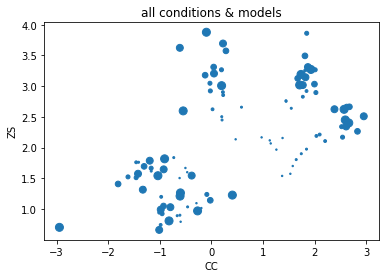

In [7]:
er_grouped.plot(
    kind='scatter',
    x='CC',
    y='ZS',
    s=er_df["width"],
    title=f"all conditions & models",
)

<AxesSubplot:title={'center':'all conditions & models'}, xlabel='CC', ylabel='PE'>

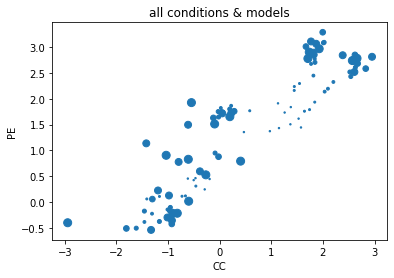

In [8]:
er_grouped.plot(
    kind='scatter',
    x='CC',
    y='PE',
    s=er_df["width"],
    title=f"all conditions & models",
)

## exemplar propensity: logit(ZS) - logit(PE)

<AxesSubplot:title={'center':'all conditions & models'}, xlabel='CC', ylabel='ZS - PE'>

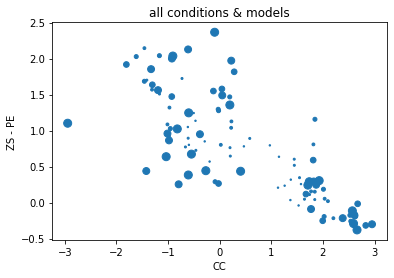

In [9]:
er_grouped.plot(
    kind='scatter',
    x='CC',
    y='ZS - PE',
    s=er_df["width"],
    title=f"all conditions & models",
)

## feature-level bias: logit(CC) - 0.5

<AxesSubplot:title={'center':'all conditions & models'}, xlabel='CC', ylabel='CC - 0.5'>

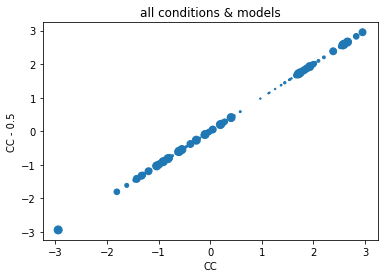

In [10]:
er_grouped.plot(
    kind='scatter',
    x='CC',
    y='CC - 0.5',
    s=er_df["width"],
    title=f"all conditions & models",
)

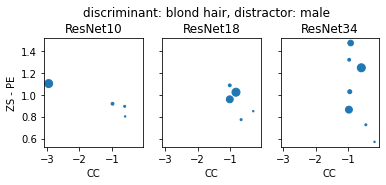

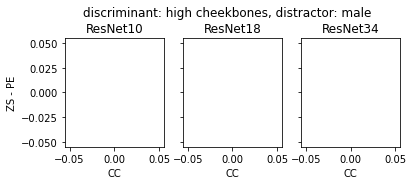

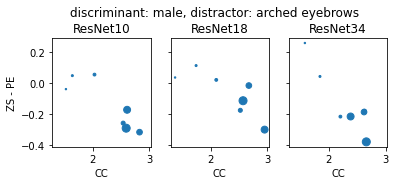

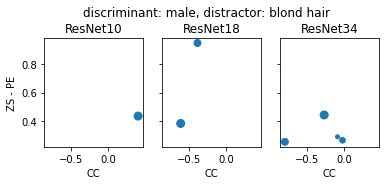

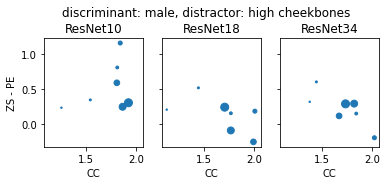

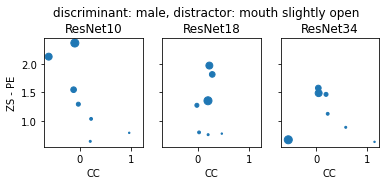

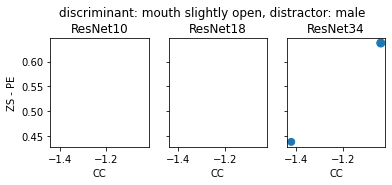

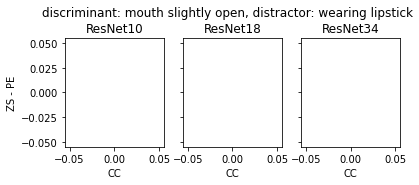

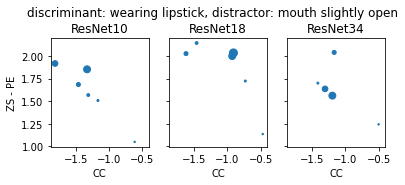

In [11]:
# Analyze CC vs ZS vs PE performance.
for attrs, group in er_df.groupby(['discriminator_attribute', 'distractor_attribute']):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
    fig.suptitle(f"discriminant: {attrs[0]}, distractor: {attrs[1]}", y=1.1)
    for i, (model, subgroup) in enumerate(group.groupby(['model'])):
        subgroup.plot(
            ax=axes[i],
            kind='scatter',
            x='CC',
            y='ZS - PE',
            s=subgroup["width"],
            figsize=(6, 2),
            title=f"{model}",
        )#.legend(bbox_to_anchor=(0.25, 1, 1, 0), ncol=1)


### Format results to input into the paper.

In [12]:
grouped = pivot(on_on_DF)

def rho_condition_performance(disc, dist, rho0, rho1, model, width):
    condition = grouped.loc[pd.IndexSlice[disc, dist, model, width]]
    return condition.loc[pd.IndexSlice['mean_ci95_string', rho0, rho1]]


def parse_performance(s):
    el = s.split(' ')
    n = el[-1].split("=")[-1][:-1]
    return float(el[0]), float(el[6].strip('%')), int(n)


def get_condition_performance(disc, dist, rho0, rho1, model):
    mean, ci95, n = parse_performance(rho_condition_performance(disc, dist, rho0, rho1, model))
    interp_dist = np.sqrt((0.5 - rho0)**2 + rho1**2)
    return f'{rho0} {rho1} {interp_dist} {mean} {ci95}'


def get_pe_baseline_zs(disc, dist, model):  
    zs_mean, zs_ci95, zs_n = parse_performance(rho_condition_performance(disc, dist, 0.0, 0.0, model))
    pe_mean, pe_ci95, pe_n = parse_performance(rho_condition_performance(disc, dist, 0.5, 0.0, model))
    
    # D(p || q)
    p = pe_mean
    q = zs_mean

    return p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
    
    #return f'{zs_mean - pe_mean}'
    
    
def get_pe_baseline_zs_sub(disc, dist, model):  
    zs_mean, zs_ci95, zs_n = parse_performance(rho_condition_performance(disc, dist, 0.0, 0.0, model))
    pe_mean, pe_ci95, pe_n = parse_performance(rho_condition_performance(disc, dist, 0.5, 0.0, model))

    return f'{zs_mean - pe_mean}'


def get_er_level(disc, dist, model):  
    cc_mean, cc_ci95, c_n = parse_performance(rho_condition_performance(disc, dist, 1.0, 0.0, model))
    zs_mean, zs_ci95, zs_n = parse_performance(rho_condition_performance(disc, dist, 0.0, 0.0, model))
    pe_mean, pe_ci95, pe_n = parse_performance(rho_condition_performance(disc, dist, 0.5, 0.0, model))
    
    # D(pe || cc)
    p = pe_mean
    q = cc_mean
    top = p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
    
    # D(zs || cc)
    p = zs_mean
    q = cc_mean
    bottom = p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
    
    return top / bottom
    
    #rho_0 = 0.5
    #return (pe_mean - cc_mean * rho_0) / (zs_mean - cc_mean * rho_0)
    
    
def logit_results(disc, dist, model, width):
    cc_mean, cc_ci95, c_n = parse_performance(rho_condition_performance(disc, dist, 1.0, 0.0, model, width))
    zs_mean, zs_ci95, zs_n = parse_performance(rho_condition_performance(disc, dist, 0.0, 0.0, model, width))
    pe_mean, pe_ci95, pe_n = parse_performance(rho_condition_performance(disc, dist, 0.5, 0.0, model, width))
    try:
        interp_mean, interp_ci95, interp_n = parse_performance(rho_condition_performance(disc, dist, 0.825, 0.25, model, width))
    except AttributeError:
        interp_mean, interp_ci95 = np.nan, np.nan
    
    return {
        'cc': cc_mean, #'cc-ci95': cc_ci95,
        'zs-pe': zs_mean - pe_mean, #'zs-pe-ci95': zs_ci95 + pe_ci95,
        'zs-interp': zs_mean - interp_mean, #'zs-interp-ci95': zs_ci95 + interp_ci95,
    }

In [13]:
def mean_ci95_str(x):
    return f"{np.mean(x)},{ci95(x)}"

import itertools
summary = []
for i, (disc, dist) in enumerate(itertools.permutations(
    ['mouth slightly open',
     'wearing lipstick',
     'male',
     'high cheekbones',
     'blond hair',
     'arched eyebrows',
    ], 2)):
    results = []
    for width in [2, 4, 8, 16, 32, 48, 64]:
        for model in ['ResNet10', 'ResNet18', 'ResNet34']:
            try:
                results += [logit_results(disc, dist, model, width)]
            except (KeyError, AttributeError):
                pass

    if results:
        summary += [pd.DataFrame(results).apply(mean_ci95_str).append(pd.Series([disc, dist]))]

In [14]:
pd.DataFrame(summary)

,cc,zs-pe,zs-interp,0,1
0,"23.28,10.643741371005524","9.429999999999993,6.070258750651582","-0.5900000000000034,1.0255688300187737",mouth slightly open,male
1,"25.143529411764707,3.6344865139433784","34.32823529411765,3.7399917875444846","-0.44411764705882417,1.483341078774471",wearing lipstick,mouth slightly open
2,"53.983333333333334,4.100430232815383","10.368095238095236,1.2907598873733692","2.6500000000000017,0.6037134502309993",male,mouth slightly open
3,"83.60666666666667,1.434995721368816","1.5319047619047619,0.7221950268145448","0.43285714285714233,0.422764601416605",male,high cheekbones
4,"43.92857142857142,7.690894164147065","8.357142857142858,3.617886572211305","-6.6228571428571446,2.291117485485516",male,blond hair
5,"89.23761904761905,2.012002985219605","-0.5585714285714294,0.6814043691149186","-3.223333333333333,0.6195041768893914",male,arched eyebrows
6,"31.151249999999997,4.683606924993948","21.560625,2.5794194818640874","-8.89666666666667,nan",blond hair,male
